In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np
import gzip

from sklearn import metrics
import tensorflow as tf

import pandas as pd
import numpy as np
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.externals import joblib


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
cd sample_data/

[Errno 2] No such file or directory: 'sample_data/'
/content/sample_data


In [35]:
import gzip

def load_data():  
  with gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open('./data/train-images-idx3-ubyte.gz', 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

In [36]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [58]:
(x_train, y_train), (x_test, y_test) = load_data()

In [37]:
train_images.shape

(60000, 28, 28)

In [38]:
test_images.shape

(10000, 28, 28)

In [39]:
len(train_labels)

60000

In [40]:
train_labels.shape

(60000,)

In [41]:
test_images.shape

(10000, 28, 28)

In [42]:
len(test_labels)

10000

In [43]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
nClasses = len(np.unique(train_labels))

In [47]:
#normalizzo da 255 colori passo a una scala di grigi
train_images = train_images.astype('float32')/255 
test_images = test_images.astype('float32')/255 

# rimodello i miei dati di input
train_images , test_images = train_images .reshape((-1,28,28,1)), test_images.reshape((-1,28,28,1))
input_shape = train_images .shape[1:]#input per la mia rete (28,28,1)
# show shapes of re-shaped tensors
print("x_train shape:", train_images.shape, ", y_train shape:", train_labels.shape)
print("x_test shape:", test_images.shape, ", y_test shape:", test_labels.shape)

# get image dimensions
img_h, img_w, img_channels = train_images.shape[1:] # size of image
print("Image height = %d, image width = %d, number of channels = %d" 
      %(img_h, img_w, img_channels))

x_train shape: (60000, 28, 28, 1) , y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) , y_test shape: (10000,)
Image height = 28, image width = 28, number of channels = 1


In [48]:
def myModel(model, ch1, ch2, kernel, pool, nDense, drop, dropDense):
    
    model = tf.keras.models.Sequential() # creazione del mio modello               
    model.add(Conv2D(ch1, kernel, padding="same", activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(ch1, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(tf.keras.layers.Dropout(drop))
    model.add(Conv2D(ch2, kernel, padding="same", activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(ch2, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(tf.keras.layers.Dropout(drop))
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(nDense, activation='relu'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropDense))
    model.add(tf.keras.layers.Dense(nClasses, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
 
    return model

In [49]:
ch1, ch2 = 32, 64 # numero di canali di output
kernel = (3,3) # filtro
pool = (2,2)
nDense = 512 # layer di collegamento
drop, dropDense = 0.25, 0.5 #per non overfittare

# creazione modello
mod = myModel('model', ch1, ch2, kernel, pool, nDense, drop, dropDense)
mod.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)       

In [50]:
batchSize = 32 # batch size per il training numero di immagini utilizzateper una passata
epochs = 50 # numero di epoche, ad ogni epoca corrisponde una passata avanti e indietro e utilizza tutte le immagini

In [51]:
mod.fit(train_images,
                 tf.keras.utils.to_categorical(train_labels, num_classes=nClasses), 
                 batch_size=batchSize,
                 epochs=epochs, 
                 validation_split = 1/6) # esecuzione del mio modello

Epoch 1/50
1563/1563 [==============================] - 10s 7ms/step - loss: 2.5335 - accuracy: 0.2688 - val_loss: 1.1264 - val_accuracy: 0.5972
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7053 - accuracy: 0.4655 - val_loss: 0.8565 - val_accuracy: 0.6851
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3826 - accuracy: 0.5596 - val_loss: 0.7482 - val_accuracy: 0.7231
Epoch 4/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2313 - accuracy: 0.6102 - val_loss: 0.6915 - val_accuracy: 0.7408
Epoch 5/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1302 - accuracy: 0.6418 - val_loss: 0.6451 - val_accuracy: 0.7597
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0602 - accuracy: 0.6617 - val_loss: 0.6176 - val_accuracy: 0.7709
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0028 - accuracy: 0.6839 - val_loss: 0.5935 - val_ac

In [95]:
predicted = mod.predict(test_images)

In [96]:
predicted[0]

array([6.30108025e-06, 7.29984749e-05, 3.20906997e-06, 1.02321792e-05,
       1.16706193e-04, 5.30242454e-04, 1.00972966e-06, 4.50552888e-02,
       1.01880556e-04, 9.54102099e-01], dtype=float32)

In [97]:
np.argmax(predicted[0])

9

In [55]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

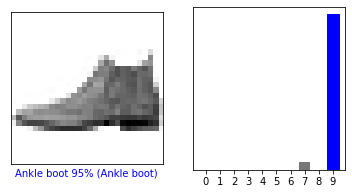

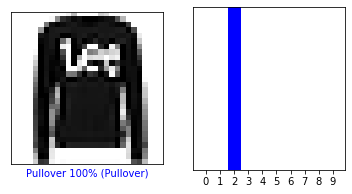

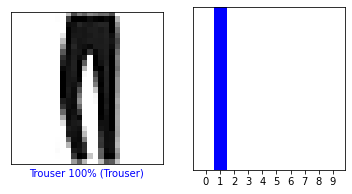

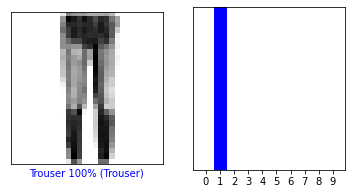

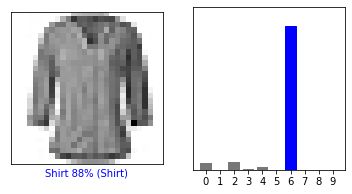

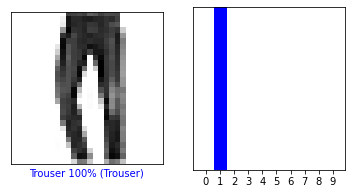

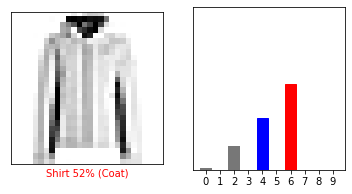

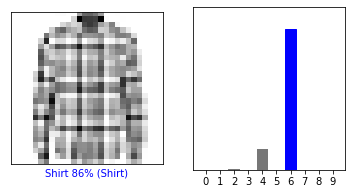

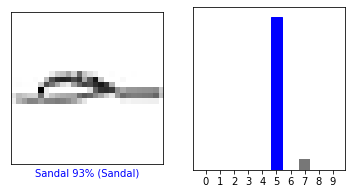

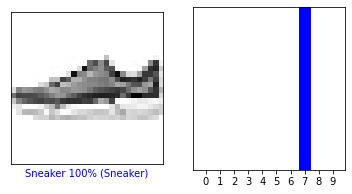

In [98]:
for i in range(nClasses):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, predicted[i], y_test, x_test)
  plt.subplot(1,2,2)
  plot_value_array(i, predicted[i],  y_test)
  plt.show()

In [112]:
import tempfile
MODEL_DIR = tempfile.gettempdir() 
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    mod,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 520
drwxr-xr-x 2 root root   4096 Jul  8 09:33 assets
-rw-r--r-- 1 root root 522993 Jul  8 09:48 saved_model.pb
drwxr-xr-x 2 root root   4096 Jul  8 09:48 variables


In [113]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  19751      0 --:--:-- --:--:-- --:--:-- 19751
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://security.

In [64]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 77 not upgraded.
Need to get 187 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.2.0 [187 MB]
Fetched 187 MB in 3s (69.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.2.0_all.deb ...
Unpacking tensorflow-model-server (2.2.0) ...
Setting up tensorflow-model-server (2.2.0) ...


In [114]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [123]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name= fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 9 in a separate thread.


In [116]:
!tail server.log

2020-07-08 09:49:03.751577: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /tmp/1
2020-07-08 09:49:03.772266: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 140484 microseconds.
2020-07-08 09:49:03.774824: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-07-08 09:49:03.774943: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name:  version: 1}
2020-07-08 09:49:03.776381: I tensorflow_serving/model_servers/server.cc:355] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 223] NET_LOG: Couldn't bind to port 8501
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now.
[evhttp_server.cc : 258]

In [109]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [117]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:nClasses].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [93]:
!pip install -q requests

<Response [200]>


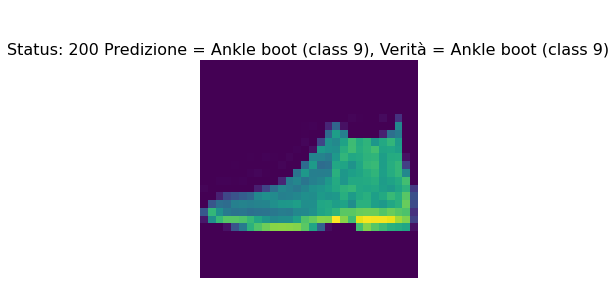

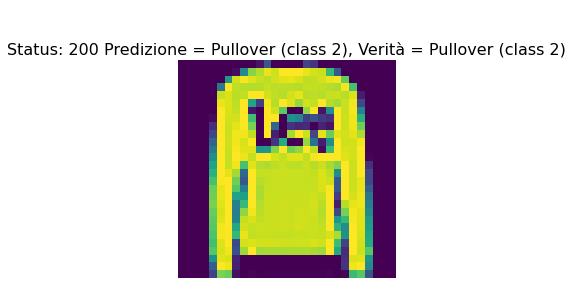

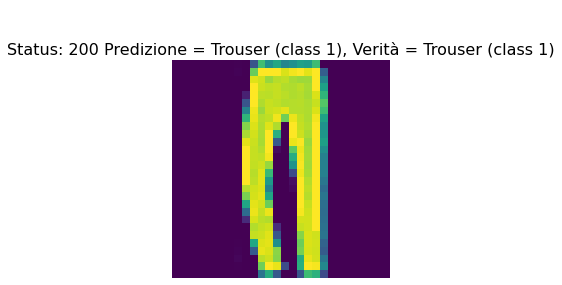

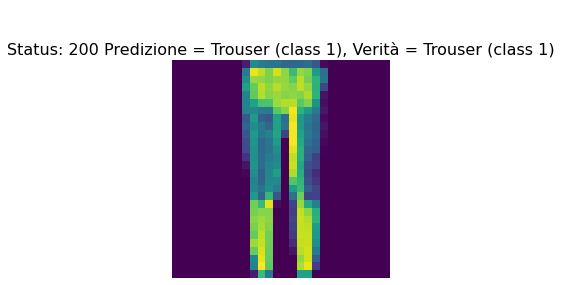

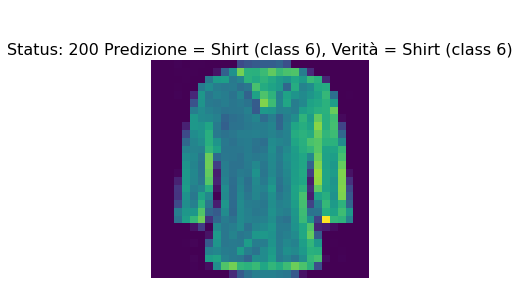

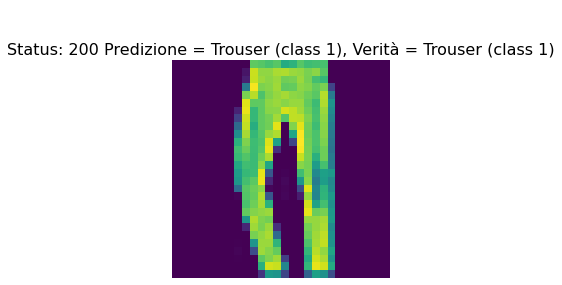

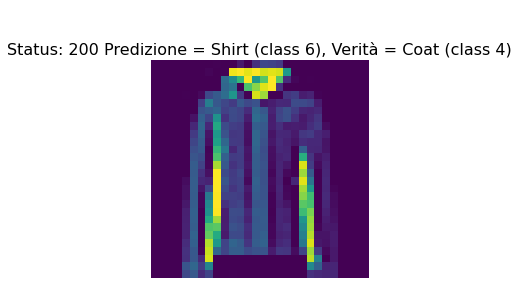

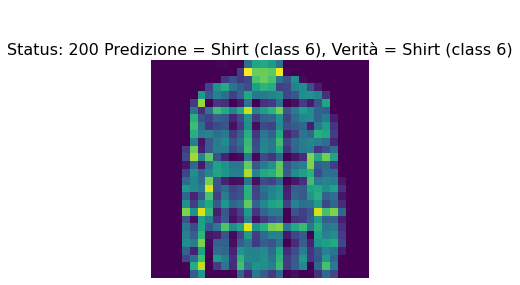

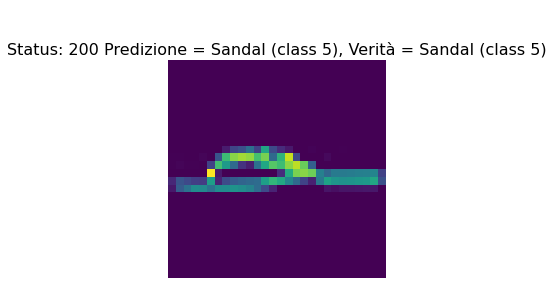

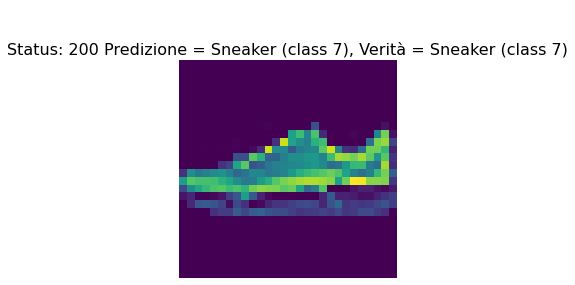

In [124]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(nClasses):
  show(i,'Status: {} Predizione = {} (class {}), Verità = {} (class {})'.format(json_response.status_code,
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))